In [15]:
import os
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# This code block gets all the comments in an unformatted way
# Useful for checking whats missing in the formatted way below
def get_comments(filepath):
  comments = []
  with open(filepath, 'r') as f:
    for line in f:
      line = line.strip()
      if line.startswith('#'):
        comments.append(line)
      else:
        break 
  return comments

def find_gpt_files(directory):
  gpt_files = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file == 'gpt.py':
        gpt_files.append(os.path.join(root, file))
  return gpt_files

def save_comments_to_csv(comments, filename):
  with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for comment in comments:
      writer.writerow([comment])  

def main():
  kattis_dir = os.path.join(os.getcwd(), 'kattis')
  gpt_files = find_gpt_files(kattis_dir)
  all_comments = []

  for filepath in gpt_files:
    comments = get_comments(filepath)
    all_comments.extend(comments)

  if all_comments:
    csv_filename = 'comments.csv'
    save_comments_to_csv(all_comments, csv_filename)
    print(f"Comments saved to CSV file: {csv_filename}")
  else:
    print("No comments found in any gpt.py files.")

if __name__ == "__main__":
  main()


Comments saved to CSV file: comments.csv


In [17]:
# This code block gives the comments in a formatted way which lets us convert to a dataframe
def get_comments(filepath):
    comments = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                comments.append(line)
            else:
                break 
    return comments

def extract_info(comment):
    # Regular expression to extract difficulty, result, and tests from comments
    pattern = r'# (\d+\.\d+) (\w+ [\w\s-]+) (\d+/\d+)'
    match = re.match(pattern, comment)
    if match:
        return match.groups()
    
    pattern_accepted = r'# (\d+\.\d+) (\w+) (\d+/\d+)' 
    match_accepted = re.match(pattern_accepted, comment)
    if match_accepted:
        return match_accepted.groups()
    return None

def find_gpt_files(directory):
    gpt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'gpt.py':
                gpt_files.append(os.path.join(root, file))
    return gpt_files

def save_comments_to_csv(comments, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Difficulty", "Result", "Tests"])
        for comment in comments:
            info = extract_info(comment)
            if info:
                writer.writerow(info)

def main():
    kattis_dir = os.path.join(os.getcwd(), 'kattis')
    gpt_files = find_gpt_files(kattis_dir)
    all_comments = []

    for filepath in gpt_files:
        comments = get_comments(filepath)
        all_comments.extend(comments)

    if all_comments:
        csv_filename = 'kattis_comments.csv'
        save_comments_to_csv(all_comments, csv_filename)
        print(f"Comments saved to CSV file: {csv_filename}")
    else:
        print("No comments found in any gpt.py files.")

if __name__ == "__main__":
    main()

Comments saved to CSV file: kattis_comments.csv


In [22]:
# Creating a dataframe from the comments csv
df_kattis = pd.read_csv("./kattis_comments.csv")
df_kattis['Result'] = df_kattis['Result'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df_kattis

,Difficulty,Result,Tests
0,3.0,wrong answer,1/19
1,2.7,wrong answer,2/19
2,4.0,wrong answer,0/13
3,2.0,accepted,52/52
4,2.3,wrong answer,0/12
...,...,...,...
150,4.5,wrong answer,0/3
151,5.3,wrong answer,0/47
152,5.4,wrong answer,0/22
153,4.7,runtime error,0/71


In [23]:
# Creating more columns for splitting the tests 
df_kattis[['Correct', 'Total']] = df_kattis['Tests'].str.split('/',expand=True).astype(int)
df_kattis

,Difficulty,Result,Tests,Correct,Total
0,3.0,wrong answer,1/19,1,19
1,2.7,wrong answer,2/19,2,19
2,4.0,wrong answer,0/13,0,13
3,2.0,accepted,52/52,52,52
4,2.3,wrong answer,0/12,0,12
...,...,...,...,...,...
150,4.5,wrong answer,0/3,0,3
151,5.3,wrong answer,0/47,0,47
152,5.4,wrong answer,0/22,0,22
153,4.7,runtime error,0/71,0,71


In [24]:
# Getting the count of each result at the difficulties
grouped = df_kattis.groupby(['Difficulty','Result']).size().unstack(fill_value=0)
grouped

Result,accepted,memory limit exceeded,runtime error,time limit exceeded,time limit exception,wrong answer
Difficulty,,,,,,
1.2,1,0,0,0,0,0
1.3,5,0,0,0,0,2
1.4,7,0,0,0,0,0
1.5,2,0,0,0,0,1
1.6,1,0,0,0,0,2
1.7,4,0,0,0,0,1
1.8,2,0,0,1,0,1
1.9,1,0,0,0,0,0
2.0,2,0,0,0,0,0


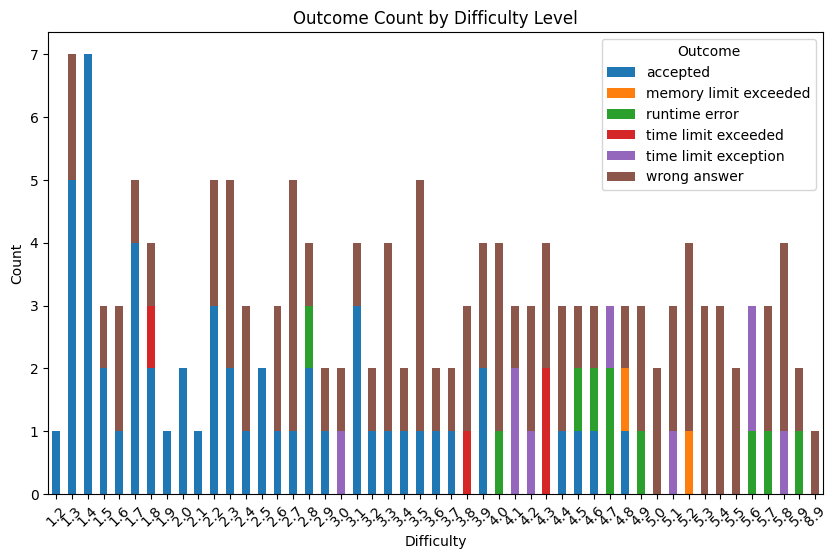

In [25]:
# Creating a stacked bar chart for each result at each difficulty
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Difficulty')
ax.set_ylabel('Count')
ax.set_title('Outcome Count by Difficulty Level')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()